# Libraries

In [1]:
# Import all libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
import sklearn
from sklearn.cluster import KMeans

!pip install folium # map rendering library
import folium

from sklearn.preprocessing import StandardScaler

print('Libraries imported.')

     |████████████████████████████████| 102kB 9.0MB/s ta 0:00:011
Libraries imported.


# Download and clean up data

In [2]:
# Download LA median income income data. This data has a year, income and neighborhood columns, 
# as well as location column, which includes latitude and longitude. 
!wget -q -O 'la_median_income.csv' https://usc.data.socrata.com/api/views/ani7-k64m/rows.csv?accessType=DOWNLOAD
print('Income data downloaded!') 

# Download LA population data. This data has a year, population and neighborhood columns, 
# as well as location column, which includes latitude and longitude. 
!wget -q -O 'la_neighborhood_population.csv' https://usc.data.socrata.com/api/views/y65w-5vdw/rows.csv?accessType=DOWNLOAD
print('Population data downloaded!')

Income data downloaded!
Population data downloaded!


In [3]:
# This is the raw income dataframe 
la_raw_income_df = pd.read_csv('la_median_income.csv')
la_raw_income_df.head()

,Policy_Area,Dataset,Variable,Year,Count,tract,tractnumber,neighborhood,GEOID,location,Row_ID,Date,Denominator,Denominator_Description
0,Employment & Income,Median Household Income,Median Household Income,2010,59454.633,Census Tract 1011.10,101110,Tujunga,1400000US06037101110,"(34.25947853, -118.29299909)",Median_Household_Income_2010_1400000US06037101110,01/01/2010 12:00:00 AM,1693.0,Total Households
1,Employment & Income,Median Household Income,Median Household Income,2010,92667.531,Census Tract 1011.22,101122,Tujunga,1400000US06037101122,"(34.26772618, -118.29015869)",Median_Household_Income_2010_1400000US06037101122,01/01/2010 12:00:00 AM,1304.0,Total Households
2,Employment & Income,Median Household Income,Median Household Income,2010,45399.477,Census Tract 1012.10,101210,Tujunga,1400000US06037101210,"(34.25297726, -118.29074307)",Median_Household_Income_2010_1400000US06037101210,01/01/2010 12:00:00 AM,2175.0,Total Households
3,Employment & Income,Median Household Income,Median Household Income,2010,52599.750,Census Tract 1012.20,101220,Tujunga,1400000US06037101220,"(34.25161333, -118.28164445)",Median_Household_Income_2010_1400000US06037101220,01/01/2010 12:00:00 AM,1173.0,Total Households
4,Employment & Income,Median Household Income,Median Household Income,2010,69783.000,Census Tract 1013,101300,Tujunga,1400000US06037101300,"(34.24878243, -118.27101097)",Median_Household_Income_2010_1400000US06037101300,01/01/2010 12:00:00 AM,1408.0,Total Households


In [4]:
# This is the raw population dataframe
la_raw_population_df = pd.read_csv('la_neighborhood_population.csv')
la_raw_population_df.head()

,Policy Area,Dataset,Variable,Year,Count,Tract,Tract Number,Neighborhood,GEOID,Location,Row ID,Date
0,Demography,Total Population,Total Population,2010,5017.0,Census Tract 1011.10,101110,Tujunga,1400000US06037101110,"(34.25947853, -118.29299909)",Total_Population_2010_1400000US06037101110,01/01/2010
1,Demography,Total Population,Total Population,2010,3663.0,Census Tract 1011.22,101122,Tujunga,1400000US06037101122,"(34.26772618, -118.29015869)",Total_Population_2010_1400000US06037101122,01/01/2010
2,Demography,Total Population,Total Population,2010,6799.0,Census Tract 1012.10,101210,Tujunga,1400000US06037101210,"(34.25297726, -118.29074307)",Total_Population_2010_1400000US06037101210,01/01/2010
3,Demography,Total Population,Total Population,2010,3189.0,Census Tract 1012.20,101220,Tujunga,1400000US06037101220,"(34.25161333, -118.28164445)",Total_Population_2010_1400000US06037101220,01/01/2010
4,Demography,Total Population,Total Population,2010,3808.0,Census Tract 1013,101300,Tujunga,1400000US06037101300,"(34.24878243, -118.27101097)",Total_Population_2010_1400000US06037101300,01/01/2010


In [5]:
# Clean up the income data. 

# We can drop columns Policy_Area, Dataset, Variable, tract, tractnumber, GEOID, Row_ID, Date, 
# Denominator, Denominator_Description 
la_income_df = la_raw_income_df.drop(['Policy_Area', 'Dataset', 'Variable', 'tract', 'tractnumber', 'GEOID', 
                                      'location', 'Row_ID', 'Date', 'Denominator', 'Denominator_Description'], 
                                     axis=1)
la_income_df.rename(columns={'Count': 'Median Income', 'neighborhood':'Neighborhood'}, inplace=True)
la_income_df.head()

,Year,Median Income,Neighborhood
0,2010,59454.633,Tujunga
1,2010,92667.531,Tujunga
2,2010,45399.477,Tujunga
3,2010,52599.750,Tujunga
4,2010,69783.000,Tujunga


In [6]:
# Clean up the population data. 

# We can drop columns Policy_Area, Dataset, Variable, tract, tractnumber, GEOID, Row_ID, Date, 
# Denominator, Denominator_Description 
la_population_df = la_raw_population_df.drop(['Policy Area', 'Dataset', 'Variable', 'Tract', 'Tract Number', 'GEOID', 
                                      'Location', 'Row ID', 'Date'], 
                                     axis=1)
la_population_df.rename(columns={'Count': 'Population', 'neighborhood':'Neighborhood'}, inplace=True)
la_population_df.head()

,Year,Population,Neighborhood
0,2010,5017.0,Tujunga
1,2010,3663.0,Tujunga
2,2010,6799.0,Tujunga
3,2010,3189.0,Tujunga
4,2010,3808.0,Tujunga


In [7]:
# Extract all 2018 income data
la_2018_income_df = la_income_df.loc[la_income_df['Year'] == 2018]
la_2018_income_df.drop(['Year'], axis=1, inplace=True)
la_2018_income_df.reset_index(drop=True, inplace=True) # Resets index and drops old index values
la_2018_income_df.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(2344, 2)

In [8]:
# Extract all 2018 population data
la_2018_population_df = la_population_df.loc[la_population_df['Year'] == 2018]
la_2018_population_df.drop(['Year'], axis=1, inplace=True)
la_2018_population_df.reset_index(drop=True, inplace=True) # Resets index and drops old index values
la_2018_population_df.shape

(2344, 2)

In [9]:
# Drop rows with missing income data
la_2018_income_df.dropna(inplace=True)
la_2018_income_df.reset_index(drop=True, inplace=True)
la_2018_income_df.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(2308, 2)

In [10]:
# Drop rows with missing population data
la_2018_population_df.dropna(inplace=True)
la_2018_population_df.reset_index(drop=True, inplace=True)
la_2018_population_df.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(2322, 2)

In [11]:
# Sort in neighborhood order
la_2018_income_df.sort_values(by=['Neighborhood'], inplace=True)
la_2018_income_df.reset_index(drop=True, inplace=True)
la_2018_income_df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Median Income,Neighborhood
0,94137.0,Acton
1,111618.0,Acton
2,36852.0,Adams-Normandie
3,46429.0,Adams-Normandie
4,20685.0,Adams-Normandie


In [12]:
# Sort in neighborhood order
la_2018_population_df.sort_values(by=['Neighborhood'], inplace=True)
la_2018_population_df.reset_index(drop=True, inplace=True)
la_2018_population_df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Population,Neighborhood
0,4687.0,Acton
1,2926.0,Acton
2,2811.0,Adams-Normandie
3,3130.0,Adams-Normandie
4,4194.0,Adams-Normandie


In [13]:
# There are several entries per neighborhood. To keep data simple, find the mean for each of the 
# neighborhoods. Drop the location column because we now want to keep one central location per
# neighborhood. We can find the latitude, longitude for each neighborhood using geolocator
la_2018_income_df = la_2018_income_df.groupby(['Neighborhood']).mean()
la_2018_income_df = la_2018_income_df.round(2)
la_2018_income_df = la_2018_income_df.reset_index(drop=False)
la_2018_income_df.head()
la_2018_income_df['Latitude'] = ""
la_2018_income_df['Longitude'] = ""
la_2018_income_df.head()

,Neighborhood,Median Income,Latitude,Longitude
0,Acton,102877.50,,
1,Adams-Normandie,34859.60,,
2,Agoura Hills,130459.67,,
3,Agua Dulce,84048.00,,
4,Alhambra,59975.25,,


In [14]:
# There are several entries per neighborhood. To keep data simple, find the total for each of the 
# neighborhoods. Drop the location column because it's coming from the income dataframe that we will
# merge with the population dataframe later on
la_2018_population_df = la_2018_population_df.groupby(['Neighborhood']).sum()
la_2018_population_df = la_2018_population_df.reset_index(drop=False)
la_2018_population_df['Population'] = la_2018_population_df['Population'].astype(int)
la_2018_population_df.head()

,Neighborhood,Population
0,Acton,7613
1,Adams-Normandie,18237
2,Agoura Hills,18943
3,Agua Dulce,4074
4,Alhambra,84974


In [15]:
# Find latitude and longitude for each neighborhood using geolocator. For those that are not
# avaialable, assign NaN for now. Note that we are looking for the location of all the neighborhoods in LA, even
# though we will later analyze only the lowest and the highest income ones. This is because we want to visualize
# where the neighborhoods are with the lowest and highest income, along with the rest of the neighborhoods.
for neighborhood in la_2018_income_df['Neighborhood']:
    address = (neighborhood+','+ 'Los Angeles')
    geolocator = Nominatim(user_agent="la_explorer")
    location = geolocator.geocode(address)
    try:
        latitude = location.latitude
        longitude = location.longitude
    except:
        latitude = np.NaN
        longitude = np.NaN
    la_2018_income_df.loc[la_2018_income_df['Neighborhood'] == neighborhood, "Latitude"] = latitude
    la_2018_income_df.loc[la_2018_income_df['Neighborhood'] == neighborhood, "Longitude"] = longitude

In [16]:
# Now the income dataframe has latitude and longitude information for each neighborhood
la_2018_income_df.head()

,Neighborhood,Median Income,Latitude,Longitude
0,Acton,102877.50,34.4807,-118.187
1,Adams-Normandie,34859.60,34.0318,-118.3
2,Agoura Hills,130459.67,34.1479,-118.766
3,Agua Dulce,84048.00,NaN,NaN
4,Alhambra,59975.25,34.093,-118.127


In [17]:
# See how many neighborhoods returned NaN location information
la_2018_income_df.isnull().sum(axis = 0)

Neighborhood      0
Median Income     0
Latitude         11
Longitude        11
dtype: int64

In [18]:
# Which neighborhoods returned NaN location
is_NaN = la_2018_income_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = la_2018_income_df[row_has_NaN]
rows_with_NaN

,Neighborhood,Median Income,Latitude,Longitude
3,Agua Dulce,84048.00,NaN,NaN
37,Castaic Canyons,97670.83,NaN,NaN
147,Northeast Antelope Valley,43513.60,NaN,NaN
149,Northwest Antelope Valley,73508.25,NaN,NaN
188,Sepulveda Basin,124038.00,NaN,NaN
194,South Diamond Bar,107500.00,NaN,NaN
202,Southeast Antelope Valley,63291.67,NaN,NaN
214,Tujunga Canyons,88345.50,NaN,NaN
215,Unincorporated Santa Monica Mountains,134605.14,NaN,NaN
216,Unincorporated Santa Susana Mountains,108205.75,NaN,NaN


In [19]:
# Drop NaN location neighborhoods
la_2018_income_df = la_2018_income_df.dropna()
la_2018_income_df.shape

(243, 4)

In [20]:
la_2018_income_df.head()

,Neighborhood,Median Income,Latitude,Longitude
0,Acton,102877.50,34.4807,-118.187
1,Adams-Normandie,34859.60,34.0318,-118.3
2,Agoura Hills,130459.67,34.1479,-118.766
4,Alhambra,59975.25,34.093,-118.127
5,Alondra Park,80688.00,33.8901,-118.335


In [21]:
# Now that our income data is clean, we want to merge this dataframe with the population
# dataframe so that we get a single dataframe that has neighborhood, income, population,
# latitude and longitude information
la_2018_merged_df = la_2018_income_df.merge(la_2018_population_df, left_on='Neighborhood', 
                                            right_on='Neighborhood', how='inner')
la_2018_merged_df = la_2018_merged_df[['Neighborhood','Population','Median Income','Latitude',
                                       'Longitude']]
la_2018_merged_df.head()

,Neighborhood,Population,Median Income,Latitude,Longitude
0,Acton,7613,102877.50,34.4807,-118.187
1,Adams-Normandie,18237,34859.60,34.0318,-118.3
2,Agoura Hills,18943,130459.67,34.1479,-118.766
3,Alhambra,84974,59975.25,34.093,-118.127
4,Alondra Park,4914,80688.00,33.8901,-118.335


In [22]:
# Let's focus on larger neighborhoods only, with population > 30,000
la_2018_larger_neighborhoods_df = la_2018_merged_df[la_2018_merged_df['Population'] >= 30000]
la_2018_larger_neighborhoods_df.shape

(120, 5)

In [27]:
# Get a list of 20 neighborhoods with the lowest Median Income
la_2018_lowest_income_df = la_2018_larger_neighborhoods_df.sort_values(by=['Median Income']).head(20)
la_2018_lowest_income_df = la_2018_lowest_income_df.reset_index(drop=True)
la_2018_lowest_income_df

,Neighborhood,Population,Median Income,Latitude,Longitude
0,Watts,45364,31559.11,33.9406,-118.243
1,Pico-Union,42250,33050.08,34.0466,-118.288
2,South Park,38810,34388.12,34.0404,-118.267
3,Historic South-Central,44932,35073.64,34.0162,-118.267
4,Westlake,112237,35582.20,34.0629,-118.273
5,Westmont,33723,35625.43,33.9414,-118.302
6,Vermont-Slauson,34975,36002.88,33.9837,-118.292
7,Exposition Park,34253,36646.86,34.0137,-118.287
8,Florence,53591,37205.23,33.9742,-118.243
9,Central-Alameda,45709,37793.90,34.004,-118.248


In [26]:
# Get a list of 20 neighborhoods with the highest Median Income. 
la_2018_highest_income_df = la_2018_larger_neighborhoods_df.sort_values(by=['Median Income'], ascending=False).head(20)
la_2018_highest_income_df = la_2018_highest_income_df.reset_index(drop=True)
la_2018_highest_income_df

,Neighborhood,Population,Median Income,Latitude,Longitude
0,Brentwood,33846,164631.20,34.0521,-118.474
1,Manhattan Beach,35573,159236.50,33.8916,-118.395
2,Rancho Palos Verdes,44986,134225.44,33.7483,-118.371
3,Beverly Hills,34362,117823.00,34.0697,-118.396
4,West Hills,39577,111965.67,34.2032,-118.645
5,Redondo Beach,67700,111911.85,33.8456,-118.389
6,Woodland Hills,59012,106937.50,34.1684,-118.606
7,Encino,48544,106607.30,34.1591,-118.502
8,Walnut,30008,106054.25,34.0203,-117.865
9,Studio City,43458,102861.44,34.1484,-118.396


In [24]:
# Get geolocator information
address = 'Los Angeles, CA'
geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [28]:
# Visualize Los Angeles neighborhoods
map_la = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, neighborhood, income in zip(la_2018_income_df['Latitude'], 
                                          la_2018_income_df['Longitude'], 
                                          la_2018_income_df['Neighborhood'],
                                         la_2018_income_df['Median Income']):
    popup_string = '{}, ${}'.format(neighborhood, str(income))
    label = folium.Popup(popup_string, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)

for lat, lng, neighborhood, income in zip(la_2018_lowest_income_df['Latitude'], 
                                          la_2018_lowest_income_df['Longitude'], 
                                          la_2018_lowest_income_df['Neighborhood'],
                                         la_2018_lowest_income_df['Median Income']):
    popup_string = '{}, ${}'.format(neighborhood, str(income))
    label = folium.Popup(popup_string, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)

for lat, lng, neighborhood, income in zip(la_2018_highest_income_df['Latitude'], 
                                          la_2018_highest_income_df['Longitude'], 
                                          la_2018_highest_income_df['Neighborhood'],
                                         la_2018_highest_income_df['Median Income']):
    popup_string = '{}, ${}'.format(neighborhood, str(income))
    label = folium.Popup(popup_string, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)    
    
map_la

# Neighborhoods with the lowest median income

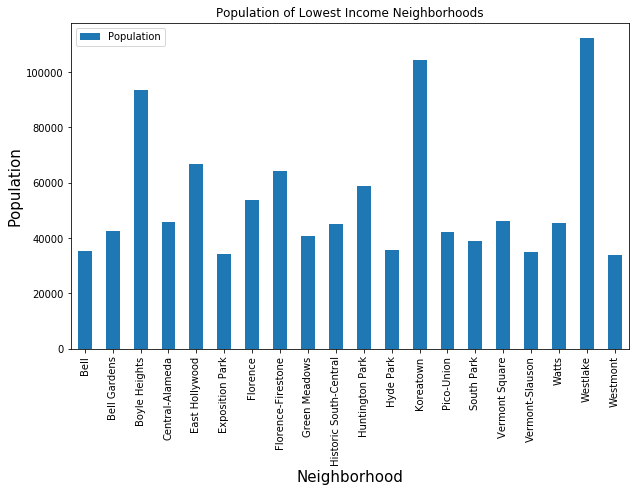

In [29]:
# Plot bar chart of population for the lowest income neighborhoods
plt.figure(figsize=(10, 6))
plt.title('Population of Lowest Income Neighborhoods')
plt.xlabel('Neighborhood', fontsize=15)
plt.ylabel('Population', fontsize=15)
la_2018_lowest_income_df.groupby('Neighborhood')['Population'].sum().plot(kind='bar')    
plt.legend()
plt.show()

In [30]:
# We want to look at population and median income
X_low = la_2018_lowest_income_df.values[:,2:4]
X_low

array([[31559.11, 33.9405674],
       [33050.08, 34.0465669],
       [34388.12, 34.0404069],
       [35073.64, 34.0162304],
       [35582.2, 34.0629226],
       [35625.43, 33.9414035],
       [36002.88, 33.9836914],
       [36646.86, 34.01365405],
       [37205.23, 33.9741588],
       [37793.9, 34.004015],
       [38734.0, 34.0019449],
       [39300.44, 34.0436892],
       [39866.16, 34.0617936],
       [40171.0, 33.9674263],
       [40592.25, 33.9409877],
       [40994.22, 34.0904277],
       [41030.6, 33.9854024],
       [41041.78, 33.9694561],
       [41869.56, 33.9827043],
       [42517.0, 33.9747806]], dtype=object)

Text(0.5, 1.0, 'Median Income and Population of Lowest Median Income Neighborhoods')

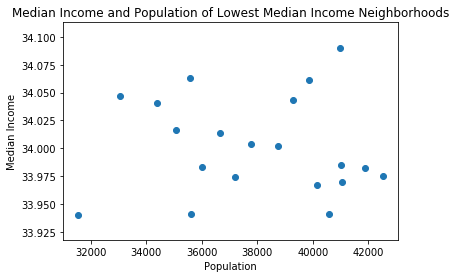

In [31]:
X_low_x, X_low_y = X_low.T
plt.scatter(X_low_x, X_low_y)
plt.xlabel('Population')
plt.ylabel('Median Income')
plt.title('Median Income and Population of Lowest Median Income Neighborhoods')

In [32]:
Clus_dataSet_low = StandardScaler().fit_transform(X_low)
Clus_dataSet_low

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-2.09947439, -1.43926646],
       [-1.60984542,  1.0396317 ],
       [-1.17043809,  0.8955743 ],
       [-0.94531589,  0.33018407],
       [-0.77830669,  1.42212515],
       [-0.76411012, -1.41971348],
       [-0.64015695, -0.4307711 ],
       [-0.42867633,  0.2699337 ],
       [-0.24530971, -0.65369993],
       [-0.05199268,  0.04451543],
       [ 0.25673264, -0.00389581],
       [ 0.44274942,  0.97233397],
       [ 0.62852975,  1.39572242],
       [ 0.72863807, -0.81114578],
       [ 0.86697499, -1.42943735],
       [ 0.99898043,  2.06535782],
       [ 1.01092749, -0.39075775],
       [ 1.01459896, -0.763677  ],
       [ 1.28643882, -0.45385536],
       [ 1.49905569, -0.63915855]])

Text(0.5, 1.0, 'Normalized Median Income and Normalized Population')

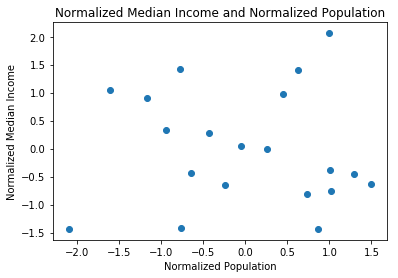

In [33]:
x_low, y_low = Clus_dataSet_low.T
plt.scatter(x_low, y_low)
plt.xlabel('Normalized Population')
plt.ylabel('Normalized Median Income')
plt.title('Normalized Median Income and Normalized Population')

In [34]:
# Function to find K-Means metrics. Plot metric for each value of K and see where the "elbow" happens
def plot_kmeans(df):
    obs = df.copy()
    number_of_clusters = range(3, 20)
    sum_of_squared_distances = []
    for i in number_of_clusters:
        classifier = KMeans(i, init='k-means++', n_init=10,
                            max_iter=300, tol=0.0001, random_state=10)
        classifier.fit(obs)
        labels = classifier.predict(obs)
        sum_of_squared_distances.append(classifier.inertia_)
    
    plt.plot(number_of_clusters, sum_of_squared_distances, 'bx-')
    plt.title("Elbow Method for Optimal K")
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.show()

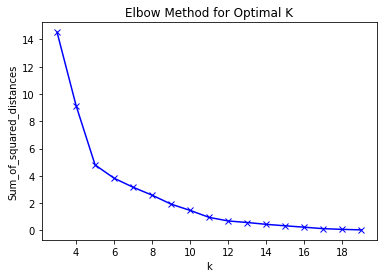

In [35]:
lowest_income_grouped_clustering = Clus_dataSet_low
plot_kmeans(lowest_income_grouped_clustering)

In [36]:
# Perform KMeans with 5 clusters, as shown above in elbow method
kmeans_low = KMeans(n_clusters = 5).fit(lowest_income_grouped_clustering)
labels_low = kmeans_low.labels_
centroids_low = kmeans_low.cluster_centers_
centroids_low

array([[-1.12597652,  0.9218788 ],
       [ 1.06777234, -0.7480053 ],
       [-0.2218806 , -0.15478354],
       [ 0.69008654,  1.47780474],
       [-1.43179226, -1.42948997]])

Text(0.5, 1.0, 'Clusters with Centroids')

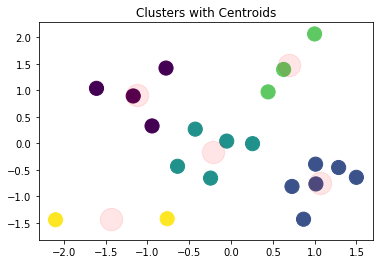

In [37]:
# Let's visualize the clusters
plt.scatter(x_low,y_low, c=labels_low, s=200, cmap='viridis')
plt.scatter(centroids_low[:, 0], centroids_low[:, 1], c='red', s=500, alpha=0.1);
plt.title('Clusters with Centroids')

In [38]:
# Now let's add the cluster labels to the neighborhoods
la_lowest_income_clusters = la_2018_lowest_income_df
la_lowest_income_clusters.insert(1, 'Cluster Label', kmeans_low.labels_)
la_lowest_income_clusters

,Neighborhood,Cluster Label,Population,Median Income,Latitude,Longitude
0,Watts,4,45364,31559.11,33.9406,-118.243
1,Pico-Union,0,42250,33050.08,34.0466,-118.288
2,South Park,0,38810,34388.12,34.0404,-118.267
3,Historic South-Central,0,44932,35073.64,34.0162,-118.267
4,Westlake,0,112237,35582.20,34.0629,-118.273
5,Westmont,4,33723,35625.43,33.9414,-118.302
6,Vermont-Slauson,2,34975,36002.88,33.9837,-118.292
7,Exposition Park,2,34253,36646.86,34.0137,-118.287
8,Florence,2,53591,37205.23,33.9742,-118.243
9,Central-Alameda,2,45709,37793.90,34.004,-118.248


In [39]:
# Group by neighborhood clusters
la_lowest_income_clusters = la_lowest_income_clusters.sort_values(by=['Cluster Label'])
la_lowest_income_clusters = la_lowest_income_clusters.reset_index(drop=True)
la_lowest_income_clusters

,Neighborhood,Cluster Label,Population,Median Income,Latitude,Longitude
0,Pico-Union,0,42250,33050.08,34.0466,-118.288
1,South Park,0,38810,34388.12,34.0404,-118.267
2,Historic South-Central,0,44932,35073.64,34.0162,-118.267
3,Westlake,0,112237,35582.20,34.0629,-118.273
4,Bell,1,35270,42517.00,33.9748,-118.187
5,Bell Gardens,1,42641,41041.78,33.9695,-118.15
6,Hyde Park,1,35852,41030.60,33.9854,-118.331
7,Green Meadows,1,40766,40592.25,33.941,-118.263
8,Florence-Firestone,1,64162,40171.00,33.9674,-118.243
9,Huntington Park,1,58694,41869.56,33.9827,-118.212


In [40]:
# Visualize the neighborhood clusters on the map
kclusters = 5
map_low_income_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(la_lowest_income_clusters['Latitude'], la_lowest_income_clusters['Longitude'], la_lowest_income_clusters['Neighborhood'], la_lowest_income_clusters['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_low_income_clusters)
    
map_low_income_clusters

In [41]:
# We want to see what kind of venues are the most common in low income neighborhoods. 
CLIENT_ID = '0W1D0ETZI5RMIRX0OTVR45XBEU0EPPABXKBU3DJS033SYYP4' # your Foursquare ID
CLIENT_SECRET = 'FLN4H0ZBHKIEYLXRONSAPRDLFTMBBUDJMAFZ2UMVFKNQCHOO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# Define a function to find url
radius = 500
limit = 100
def getNearbyVenues(names, latitudes, longitudes):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            limit
            )

        results = requests.get(url).json()['response']['groups'][0]['items']
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for
                                  item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude',
                             'Neighborhood Longitude', 'Venue', 'Venue Latitude',
                             'Venue Longitude', 'Venue Category']
    return(nearby_venues)

In [42]:
# Call function to get nearby venues of lowest income neighborhoods
lowest_income_venues = getNearbyVenues(names=la_lowest_income_clusters['Neighborhood'], 
                                   latitudes=la_lowest_income_clusters['Latitude'],
                                   longitudes=la_lowest_income_clusters['Longitude'])

In [43]:
lowest_income_venues.shape

(371, 7)

In [44]:
lowest_income_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Pico-Union,34.046567,-118.287894,El Grullense,34.047043,-118.286201,Mexican Restaurant
1,Pico-Union,34.046567,-118.287894,El Colmao,34.046959,-118.287397,Cuban Restaurant
2,Pico-Union,34.046567,-118.287894,Happy Taco,34.046923,-118.284384,Taco Place
3,Pico-Union,34.046567,-118.287894,Pollos El Brasero,34.047469,-118.286236,South American Restaurant
4,Pico-Union,34.046567,-118.287894,Mateo's Ice Cream & Fruit Bars,34.047787,-118.290994,Ice Cream Shop


In [45]:
lowest_income_merged = lowest_income_venues.merge(la_lowest_income_clusters, left_on='Neighborhood', 
                                            right_on='Neighborhood', how='inner')
lowest_income_merged = lowest_income_merged[['Cluster Label', 'Neighborhood','Neighborhood Latitude','Neighborhood Longitude',
                                             'Population', 'Median Income', 'Venue', 'Venue Latitude', 'Venue Longitude', 
                                             'Venue Category']]
lowest_income_merged.head()

,Cluster Label,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Population,Median Income,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Pico-Union,34.046567,-118.287894,42250,33050.08,El Grullense,34.047043,-118.286201,Mexican Restaurant
1,0,Pico-Union,34.046567,-118.287894,42250,33050.08,El Colmao,34.046959,-118.287397,Cuban Restaurant
2,0,Pico-Union,34.046567,-118.287894,42250,33050.08,Happy Taco,34.046923,-118.284384,Taco Place
3,0,Pico-Union,34.046567,-118.287894,42250,33050.08,Pollos El Brasero,34.047469,-118.286236,South American Restaurant
4,0,Pico-Union,34.046567,-118.287894,42250,33050.08,Mateo's Ice Cream & Fruit Bars,34.047787,-118.290994,Ice Cream Shop


In [46]:
# How many venues for each neighbourhood
lowest_income_merged.groupby('Cluster Label').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Population,Median Income,Venue,Venue Latitude,Venue Longitude,Venue Category
Cluster Label,,,,,,,,,
0,95,95,95,95,95,95,95,95,95
1,64,64,64,64,64,64,64,64,64
2,80,80,80,80,80,80,80,80,80
3,115,115,115,115,115,115,115,115,115
4,17,17,17,17,17,17,17,17,17


In [47]:
# How many unique categories
print("There are {} unique categories.".format(len(lowest_income_merged['Venue Category'].unique())))

There are 122 unique categories.


In [48]:
# Let's analyze each neighborhood
lowest_income_onehot = pd.get_dummies(lowest_income_merged[['Venue Category']], prefix="", prefix_sep="")
lowest_income_onehot['Cluster Label'] = lowest_income_merged['Cluster Label']
# Move Cluster Label to first column
lowest_income_onehot = lowest_income_onehot[['Cluster Label'] + [col for col in lowest_income_onehot.columns
                                                         if col != 'Cluster Label']]
lowest_income_onehot.head()

,Cluster Label,ATM,Accessories Store,American Restaurant,Amphitheater,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Supermarket,Sushi Restaurant,Taco Place,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Store,Wings Joint,Women's Store,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# Group each cluster and take mean of frequency of occurence of each category
lowest_income_grouped = lowest_income_onehot.groupby('Cluster Label').mean().reset_index()
lowest_income_grouped

,Cluster Label,ATM,Accessories Store,American Restaurant,Amphitheater,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Supermarket,Sushi Restaurant,Taco Place,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Video Store,Wings Joint,Women's Store,Zoo Exhibit
0,0,0.000000,0.000000,0.031579,0.0000,0.000,0.010526,0.010526,0.000000,0.010526,...,0.010526,0.021053,0.010526,0.010526,0.010526,0.000000,0.000000,0.000000,0.000000,0.0000
1,1,0.015625,0.015625,0.015625,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.015625,0.000000,0.015625,0.015625,0.000000,0.015625,0.000000,0.015625,0.000000,0.0000
2,2,0.000000,0.000000,0.000000,0.0125,0.025,0.000000,0.000000,0.000000,0.012500,...,0.000000,0.000000,0.012500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0125
3,3,0.008696,0.000000,0.000000,0.0000,0.000,0.000000,0.000000,0.017391,0.000000,...,0.000000,0.017391,0.008696,0.008696,0.008696,0.000000,0.008696,0.000000,0.000000,0.0000
4,4,0.000000,0.000000,0.000000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.0000


In [50]:
# Create dataframe with top 10 venues for each cluster
columns = ['Cluster Label']
num_top_venues = 20
indicators = ['st', 'nd', 'rd']
for ind in range(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
lowest_income_sorted = pd.DataFrame(columns=columns)
lowest_income_sorted['Cluster Label'] = lowest_income_grouped['Cluster Label']
lowest_income_sorted

,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Function to find most common venues. Some clusters don't have 20 venues located within 
# 500 meters. 
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    for i in range(num_top_venues):
        if row_categories_sorted[i] == 0:
            row_categories_sorted.index.values[i] = ''
    return row_categories_sorted.index.values[0:num_top_venues]

for neigh in range(lowest_income_grouped.shape[0]):
    lowest_income_sorted.iloc[neigh,1:] = return_most_common_venues(lowest_income_grouped.iloc[neigh,:], num_top_venues)
lowest_income_sorted

,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,0,Mexican Restaurant,Coffee Shop,Food Truck,Fast Food Restaurant,American Restaurant,Clothing Store,Sports Bar,Bar,Grocery Store,...,Donut Shop,Sushi Restaurant,Restaurant,Bakery,Music Venue,Basketball Court,Café,Concert Hall,Monument / Landmark,Cocktail Bar
1,1,Mexican Restaurant,Fried Chicken Joint,Burger Joint,Pizza Place,Sandwich Place,Donut Shop,Fast Food Restaurant,Pharmacy,Food,...,Convenience Store,Other Repair Shop,Chinese Restaurant,New American Restaurant,Park,Department Store,Pet Store,Clothing Store,Coffee Shop,Motel
2,2,Science Museum,History Museum,Mexican Restaurant,Burger Joint,Museum,Sandwich Place,Park,Food Court,Aquarium,...,Food,Clothing Store,Light Rail Station,College Football Field,Other Great Outdoors,Organic Grocery,Amphitheater,Moving Target,Movie Theater,Check Cashing Service
3,3,Korean Restaurant,Café,Bakery,Restaurant,Grocery Store,Ice Cream Shop,Coffee Shop,Burger Joint,Convenience Store,...,Food Truck,Bubble Tea Shop,Brazilian Restaurant,Sushi Restaurant,Mexican Restaurant,BBQ Joint,Pharmacy,Dessert Shop,Asian Restaurant,Fast Food Restaurant
4,4,Donut Shop,Fast Food Restaurant,Performing Arts Venue,Mobile Phone Shop,Sculpture Garden,Sandwich Place,Café,Bank,Fried Chicken Joint,...,Light Rail Station,Taco Place,Grocery Store,Women's Store,Pharmacy,,,,,


In [52]:
# What is the count of different types of venues, like restaurants, bars, bus stations, healthcare, etc in the clusters? Can we see any
# interesting difference between the low and the high income neighborhoods?
# For simplicity, we can group the venues as follows:
#  - groceries and convenience stores
#  - all food related businesses, except health foods and juice bars
#  - money/Bank/ATM related businesses 
#  - transportation services like bus stops, train stations, etc. 
#  - shopping like clothing stores
#  - parks, gardens and nature trails
#  - lifestyle stores like spas, gyms, health foods, juice bars, etc.
#  - health related like hospitals, pharmacies, clinics
#  - entertainment like theaters, museums, aquariums
def count_venues(input_df):
    columns = ['Cluster Label', 'Groceries', 'Food', 'Finance', 'Transport', 'Shopping', 'Parks', 'Lifestyle', 'Health', 'Entertainment']

    output_df = pd.DataFrame(columns=columns)

    for row in range(input_df.shape[0]):
        count_groceries = input_df.loc[row].str.contains(r'Grocer|Convenien').sum()
        count_food = input_df.loc[row].str.contains(r'Restau|Baker|Food|Pizza|Coff|Caf|BBQ|Sandwich|Ice Cream|Burger|Taco|Donut|Fried Chicken').sum()
        count_finance = input_df.loc[row].str.contains(r'ATM|Bank').sum()
        count_transport = input_df.loc[row].str.contains(r'Bus |Train|Rail').sum()
        count_shopping = input_df.loc[row].str.contains(r'Clothing|Shoe|Boutique').sum()
        count_parks = input_df.loc[row].str.contains(r'Trail|Park|Camp|Tree|Beach|Scenic|Garden').sum()
        count_lifestyle = input_df.loc[row].str.contains(r'Spa|Gym|Health|Juice|Pilates').sum()
        count_health = input_df.loc[row].str.contains(r'Hospital|Clinic|Doctor|Dentist|Pharmacy').sum()
        count_entertainment = input_df.loc[row].str.contains(r'Entertain|Theater|Performing Arts|Museum|Aquarium').sum()

        output_df.at[row, 'Cluster Label'] = row
        output_df.at[row, 'Groceries'] = count_groceries
        output_df.at[row, 'Food'] = count_food
        output_df.at[row, 'Finance'] = count_finance
        output_df.at[row, 'Transport'] = count_transport
        output_df.at[row, 'Shopping'] = count_shopping
        output_df.at[row, 'Parks'] = count_parks
        output_df.at[row, 'Lifestyle'] = count_lifestyle
        output_df.at[row, 'Health'] = count_health
        output_df.at[row, 'Entertainment'] = count_entertainment
    return(output_df)

In [53]:
# Count venue by type 
lowest_venues_count = count_venues(lowest_income_sorted)
lowest_venues_count

,Cluster Label,Groceries,Food,Finance,Transport,Shopping,Parks,Lifestyle,Health,Entertainment
0,0,1,11,0,0,1,0,0,0,0
1,1,2,11,0,0,1,1,0,1,0
2,2,1,6,0,1,1,1,0,0,5
3,3,2,15,0,0,0,0,0,1,0
4,4,1,6,1,1,0,1,0,1,1


# Neighborhoods with highest median income

In [54]:
# Let's take a look at the highest median income neighborhoods again
la_2018_highest_income_df

,Neighborhood,Population,Median Income,Latitude,Longitude
0,Brentwood,33846,164631.20,34.0521,-118.474
1,Manhattan Beach,35573,159236.50,33.8916,-118.395
2,Rancho Palos Verdes,44986,134225.44,33.7483,-118.371
3,Beverly Hills,34362,117823.00,34.0697,-118.396
4,West Hills,39577,111965.67,34.2032,-118.645
5,Redondo Beach,67700,111911.85,33.8456,-118.389
6,Woodland Hills,59012,106937.50,34.1684,-118.606
7,Encino,48544,106607.30,34.1591,-118.502
8,Walnut,30008,106054.25,34.0203,-117.865
9,Studio City,43458,102861.44,34.1484,-118.396


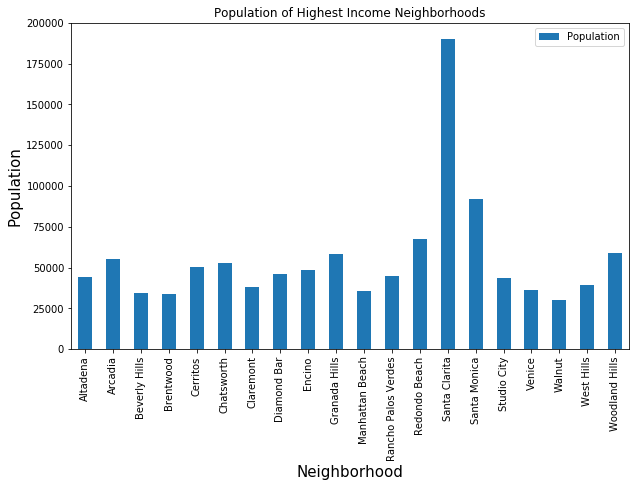

In [55]:
# Plot bar chart of population for the highest income neighborhoods
plt.figure(figsize=(10, 6))
plt.title('Population of Highest Income Neighborhoods')
plt.xlabel('Neighborhood', fontsize=15)
plt.ylabel('Population', fontsize=15)
la_2018_highest_income_df.groupby('Neighborhood')['Population'].sum().plot(kind='bar')    
plt.legend()
plt.show()

In [56]:
# Looking at population and median income
X_high = la_2018_highest_income_df.values[:,2:4]
X_high

array([[164631.2, 34.0521403],
       [159236.5, 33.8915985],
       [134225.44, 33.7483311],
       [117823.0, 34.0696501],
       [111965.67, 34.2032325],
       [111911.85, 33.8455911],
       [106937.5, 34.1684364],
       [106607.3, 34.1591324],
       [106054.25, 34.0202894],
       [102861.44, 34.1483989],
       [101770.45, 33.995044],
       [101168.0, 33.8644291],
       [99502.98, 34.3916641],
       [98199.32, 34.0250724],
       [98151.0, 34.2661558],
       [98002.62, 34.2595715],
       [96364.0, 34.1863161],
       [96302.5, 34.0966764],
       [96191.0, 34.1362075],
       [95933.11, 34.0286226]], dtype=object)

Text(0.5, 1.0, 'Median Income and Population of Highest Median Income Neighborhoods')

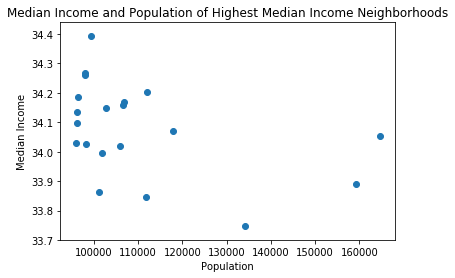

In [57]:
X_high_x, X_high_y = X_high.T
plt.scatter(X_high_x, X_high_y)
plt.xlabel('Population')
plt.ylabel('Median Income')
plt.title('Median Income and Population of Highest Median Income Neighborhoods')

In [58]:
# Normalize the data
Clus_dataSet_high = StandardScaler().fit_transform(X_high)
Clus_dataSet_high

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 2.79401487, -0.16635696],
       [ 2.51713975, -1.20604657],
       [ 1.23348353, -2.13386492],
       [ 0.39165219, -0.05296121],
       [ 0.09103326,  0.81213582],
       [ 0.08827103, -1.50399649],
       [-0.16703024,  0.58679174],
       [-0.18397727,  0.52653782],
       [-0.21236176, -0.37262753],
       [-0.37622808,  0.45702628],
       [-0.43222155, -0.53612003],
       [-0.46314142, -1.38199914],
       [-0.54859615,  2.03244341],
       [-0.6155046 , -0.3416522 ],
       [-0.61798455,  1.2196353 ],
       [-0.62559994,  1.17699452],
       [-0.70969972,  0.70258301],
       [-0.71285612,  0.12206463],
       [-0.7185787 ,  0.37807318],
       [-0.73181453, -0.31866065]])

Text(0.5, 1.0, 'Normalized Median Income and Normalized Population of Highest Median Income Neighborhoods')

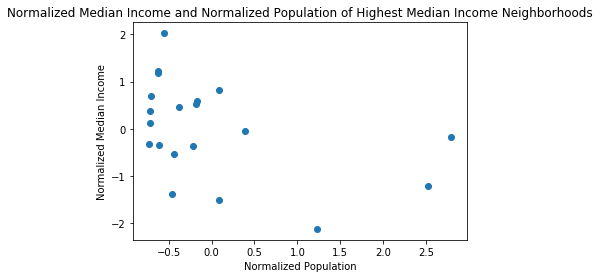

In [59]:
x_high, y_high = Clus_dataSet_high.T
plt.scatter(x_high, y_high)
plt.xlabel('Normalized Population')
plt.ylabel('Normalized Median Income')
plt.title('Normalized Median Income and Normalized Population of Highest Median Income Neighborhoods')

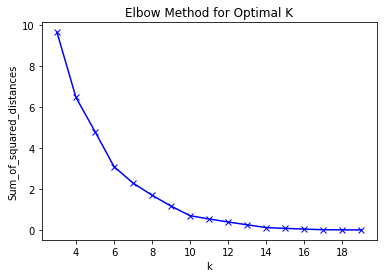

In [60]:
# Determine K using elbow method
highest_income_grouped_clustering = Clus_dataSet_high
plot_kmeans(highest_income_grouped_clustering)

In [61]:
# Perform KMeans with 6 clusters, as shown above in elbow method
kmeans_high = KMeans(n_clusters = 6).fit(highest_income_grouped_clustering)
labels_high = kmeans_high.labels_
centroids_high = kmeans_high.cluster_centers_
centroids_high

array([[-0.59739355,  1.47635774],
       [-0.1874352 , -1.44299782],
       [-0.32005005, -0.32440433],
       [ 2.65557731, -0.68620176],
       [-0.39676241,  0.51217321],
       [ 1.23348353, -2.13386492]])

Text(0.5, 1.0, 'Clusters with Centroids')

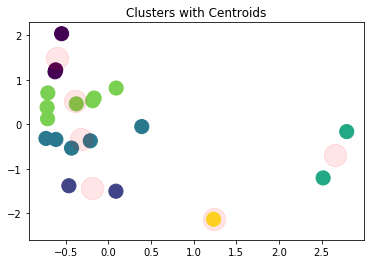

In [62]:
# Let's visualize the clusters
plt.scatter(x_high,y_high, c=labels_high, s=200, cmap='viridis')
plt.scatter(centroids_high[:, 0], centroids_high[:, 1], c='red', s=500, alpha=0.1);
plt.title('Clusters with Centroids')

In [63]:
# Now let's add the cluster labels to the neighborhoods
la_highest_income_clusters = la_2018_highest_income_df
la_highest_income_clusters.insert(1, 'Cluster Label', kmeans_high.labels_)
la_highest_income_clusters

,Neighborhood,Cluster Label,Population,Median Income,Latitude,Longitude
0,Brentwood,3,33846,164631.20,34.0521,-118.474
1,Manhattan Beach,3,35573,159236.50,33.8916,-118.395
2,Rancho Palos Verdes,5,44986,134225.44,33.7483,-118.371
3,Beverly Hills,2,34362,117823.00,34.0697,-118.396
4,West Hills,4,39577,111965.67,34.2032,-118.645
5,Redondo Beach,1,67700,111911.85,33.8456,-118.389
6,Woodland Hills,4,59012,106937.50,34.1684,-118.606
7,Encino,4,48544,106607.30,34.1591,-118.502
8,Walnut,2,30008,106054.25,34.0203,-117.865
9,Studio City,4,43458,102861.44,34.1484,-118.396


In [64]:
# Group by neighborhood clusters
la_highest_income_clusters = la_highest_income_clusters.sort_values(by=['Cluster Label'])
la_highest_income_clusters = la_highest_income_clusters.reset_index(drop=True)
la_highest_income_clusters

,Neighborhood,Cluster Label,Population,Median Income,Latitude,Longitude
0,Chatsworth,0,52706,98002.62,34.2596,-118.602
1,Granada Hills,0,58088,98151.00,34.2662,-118.517
2,Santa Clarita,0,190304,99502.98,34.3917,-118.543
3,Redondo Beach,1,67700,111911.85,33.8456,-118.389
4,Cerritos,1,50172,101168.00,33.8644,-118.054
5,Diamond Bar,2,46346,95933.11,34.0286,-117.81
6,Beverly Hills,2,34362,117823.00,34.0697,-118.396
7,Santa Monica,2,92078,98199.32,34.0251,-118.497
8,Walnut,2,30008,106054.25,34.0203,-117.865
9,Venice,2,36149,101770.45,33.995,-118.467


In [65]:
# Visualize the neighborhood clusters on the map
kclusters = 6
map_high_income_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(la_highest_income_clusters['Latitude'], la_highest_income_clusters['Longitude'], la_highest_income_clusters['Neighborhood'], la_highest_income_clusters['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_high_income_clusters)
    
map_high_income_clusters

In [66]:
# Call function to get nearby venues of lowest income neighborhoods
highest_income_venues = getNearbyVenues(names=la_highest_income_clusters['Neighborhood'], 
                                   latitudes=la_highest_income_clusters['Latitude'],
                                   longitudes=la_highest_income_clusters['Longitude'])

In [67]:
highest_income_venues.shape

(480, 7)

In [68]:
highest_income_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chatsworth,34.259571,-118.602325,Los Toros Mexican Restaurant,34.257465,-118.603330,Mexican Restaurant
1,Chatsworth,34.259571,-118.602325,Pho Saigon 1,34.257445,-118.602143,Vietnamese Restaurant
2,Chatsworth,34.259571,-118.602325,Les Sisters,34.257083,-118.604559,Cajun / Creole Restaurant
3,Chatsworth,34.259571,-118.602325,Naya Fresh Body Spa AVEDA,34.256988,-118.604082,Spa
4,Chatsworth,34.259571,-118.602325,Cowboy Palace Saloon,34.257469,-118.601538,Rock Club


In [69]:
highest_income_merged = highest_income_venues.merge(la_highest_income_clusters, left_on='Neighborhood', 
                                            right_on='Neighborhood', how='inner')
highest_income_merged = highest_income_merged[['Cluster Label', 'Neighborhood','Neighborhood Latitude','Neighborhood Longitude',
                                             'Population', 'Median Income', 'Venue', 'Venue Latitude', 'Venue Longitude', 
                                             'Venue Category']]
highest_income_merged.head()

,Cluster Label,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Population,Median Income,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Chatsworth,34.259571,-118.602325,52706,98002.62,Los Toros Mexican Restaurant,34.257465,-118.603330,Mexican Restaurant
1,0,Chatsworth,34.259571,-118.602325,52706,98002.62,Pho Saigon 1,34.257445,-118.602143,Vietnamese Restaurant
2,0,Chatsworth,34.259571,-118.602325,52706,98002.62,Les Sisters,34.257083,-118.604559,Cajun / Creole Restaurant
3,0,Chatsworth,34.259571,-118.602325,52706,98002.62,Naya Fresh Body Spa AVEDA,34.256988,-118.604082,Spa
4,0,Chatsworth,34.259571,-118.602325,52706,98002.62,Cowboy Palace Saloon,34.257469,-118.601538,Rock Club


In [70]:
# How many venues for each neighbourhood
highest_income_merged.groupby('Cluster Label').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Population,Median Income,Venue,Venue Latitude,Venue Longitude,Venue Category
Cluster Label,,,,,,,,,
0,42,42,42,42,42,42,42,42,42
1,47,47,47,47,47,47,47,47,47
2,163,163,163,163,163,163,163,163,163
3,50,50,50,50,50,50,50,50,50
4,175,175,175,175,175,175,175,175,175
5,3,3,3,3,3,3,3,3,3


In [71]:
# How many unique categories
print("There are {} unique categories.".format(len(highest_income_merged['Venue Category'].unique())))

There are 149 unique categories.


In [72]:
# Let's analyze each neighborhood
highest_income_onehot = pd.get_dummies(highest_income_merged[['Venue Category']], prefix="", prefix_sep="")
highest_income_onehot['Cluster Label'] = highest_income_merged['Cluster Label']
# Move Cluster Label to first column
highest_income_onehot = highest_income_onehot[['Cluster Label'] + [col for col in highest_income_onehot.columns
                                                         if col != 'Cluster Label']]
highest_income_onehot.head()

,Cluster Label,ATM,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,...,Thrift / Vintage Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
# Group each cluster and take mean of frequency of occurence of each category
highest_income_grouped = highest_income_onehot.groupby('Cluster Label').mean().reset_index()
highest_income_grouped

,Cluster Label,ATM,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,...,Thrift / Vintage Store,Track,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.02381,0.000000,0.000000,0.02381
1,1,0.000000,0.021277,0.021277,0.000000,0.000000,0.000000,0.000000,0.021277,0.021277,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.00000
2,2,0.006135,0.000000,0.030675,0.006135,0.000000,0.006135,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.018405,0.00,0.000000,0.00000,0.018405,0.006135,0.00000
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.020000,0.020000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.02,0.020000,0.00000,0.000000,0.000000,0.00000
4,4,0.005714,0.000000,0.022857,0.000000,0.022857,0.011429,0.005714,0.000000,0.011429,...,0.005714,0.005714,0.000000,0.005714,0.00,0.011429,0.00000,0.005714,0.000000,0.00000
5,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.333333,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.00000


In [74]:
# Create dataframe with top 10 venues for each cluster
columns = ['Cluster Label']
num_top_venues = 20
indicators = ['st', 'nd', 'rd']
for ind in range(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
highest_income_sorted = pd.DataFrame(columns=columns)
highest_income_sorted['Cluster Label'] = highest_income_grouped['Cluster Label']
highest_income_sorted

,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
for neigh in range(highest_income_grouped.shape[0]):
    highest_income_sorted.iloc[neigh,1:] = return_most_common_venues(highest_income_grouped.iloc[neigh,:], num_top_venues)
highest_income_sorted

,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,0,Mexican Restaurant,Smoke Shop,Convenience Store,Pizza Place,Park,Business Service,Fast Food Restaurant,Food Truck,Home Service,...,Café,Cajun / Creole Restaurant,Rock Club,Restaurant,Rental Car Location,Photography Studio,Middle Eastern Restaurant,Construction & Landscaping,Hotel,Cosmetics Shop
1,1,Seafood Restaurant,Bar,Coffee Shop,Juice Bar,Hotel,Café,Burger Joint,Diner,Pharmacy,...,Grocery Store,Poke Place,Spa,Pet Store,Park,Chinese Restaurant,Electronics Store,Salon / Barbershop,Sandwich Place,Mexican Restaurant
2,2,Coffee Shop,Boutique,Café,Bank,American Restaurant,Clothing Store,Sandwich Place,Pizza Place,Park,...,Sushi Restaurant,Hotel,Spa,Mexican Restaurant,New American Restaurant,Vegetarian / Vegan Restaurant,Gym / Fitness Center,Wine Bar,Cosmetics Shop,Food Truck
3,3,Coffee Shop,Italian Restaurant,Bank,Clothing Store,Gym / Fitness Center,Sandwich Place,Hotel,Sports Bar,Pharmacy,...,Bus Station,Café,Rental Car Location,Gourmet Shop,Pizza Place,Pilates Studio,Dance Studio,Shipping Store,Mobile Phone Shop,Farmers Market
4,4,Coffee Shop,Mediterranean Restaurant,Ice Cream Shop,Sushi Restaurant,Pizza Place,Bakery,Spa,American Restaurant,Arts & Crafts Store,...,Grocery Store,Mexican Restaurant,Park,Gastropub,Pet Store,Bank,Bagel Shop,Italian Restaurant,Farmers Market,Donut Shop
5,5,Sporting Goods Shop,Furniture / Home Store,Trail,,,,,,,...,,,,,,,,,,


In [76]:
# Count venue by type 
highest_venues_count = count_venues(highest_income_sorted)
highest_venues_count

,Cluster Label,Groceries,Food,Finance,Transport,Shopping,Parks,Lifestyle,Health,Entertainment
0,0,1,8,0,0,0,1,0,0,0
1,1,1,8,0,0,0,1,2,1,0
2,2,0,11,1,0,2,1,2,0,0
3,3,0,5,1,1,1,0,2,1,0
4,4,1,11,1,0,0,1,1,0,0
5,5,0,0,0,0,0,1,0,0,0


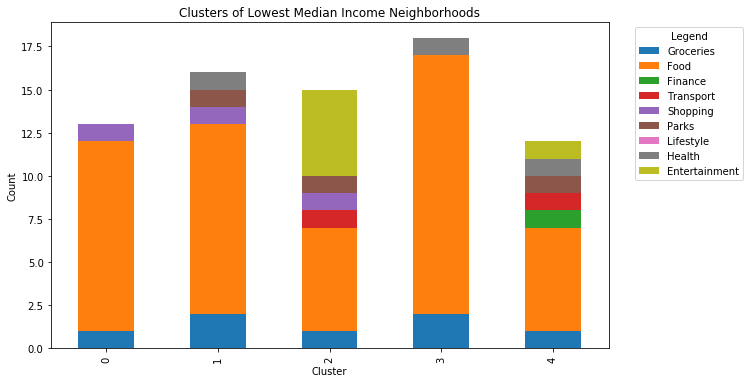

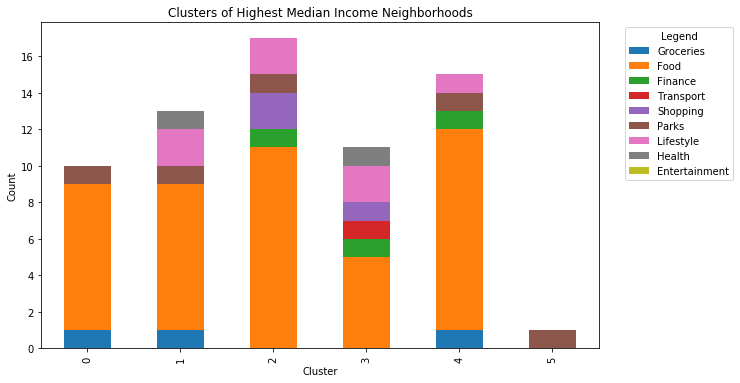

In [77]:
axis_low = lowest_venues_count.iloc[:, 1:].plot(kind="bar", stacked=True, figsize=(10,6))
axis_low.set_xlabel('Cluster')
axis_low.set_ylabel('Count')
axis_low.set_title('Clusters of Lowest Median Income Neighborhoods')
axis_low.legend(loc='upper right', title='Legend', bbox_to_anchor=(1.25, 1))
axis_high = highest_venues_count.iloc[:, 1:].plot(kind="bar", stacked=True, figsize=(10,6))
axis_high.set_xlabel('Cluster')
axis_high.set_ylabel('Count')
axis_high.set_title('Clusters of Highest Median Income Neighborhoods')
axis_high.legend(loc='upper right', title='Legend', bbox_to_anchor=(1.25, 1))

In [90]:
columns = ['Lowest Median Income', 'Highest Median Income']
venues_count_parks_lifestyle = pd.DataFrame(columns = columns)
venues_count_parks_lifestyle['Lowest Median Income'] = lowest_venues_count[['Parks', 'Lifestyle']].sum(axis=1)
venues_count_parks_lifestyle['Highest Median Income'] = highest_venues_count[['Parks', 'Lifestyle']].sum(axis=1)
venues_count_parks_lifestyle

,Lowest Median Income,Highest Median Income
0,0.0,1.0
1,1.0,3.0
2,1.0,3.0
3,0.0,2.0
4,1.0,2.0


In [93]:
lowest_count = venues_count_parks_lifestyle['Lowest Median Income'].sum()
highest_count = venues_count_parks_lifestyle['Highest Median Income'].sum()
park_lifestyle_count_list = [lowest_count, highest_count]
park_lifestyle_count_list

[3.0, 11.0]

In [94]:
bars = ['Lowest Median Income', 'Highest Median Income']

<BarContainer object of 2 artists>

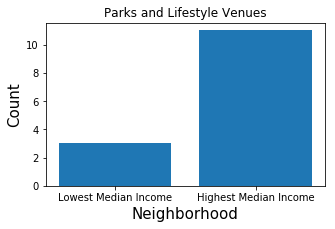

In [97]:
# Plot bar chart of population for the highest income neighborhoods
plt.figure(figsize=(5, 3))
plt.title('Parks and Lifestyle Venues')
plt.xlabel('Neighborhood', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.bar(bars, park_lifestyle_count_list, align='center')